data processing
===============


Outlier detection
---------

Compression
-----------

* data in time-series, reduce the whole series to one observation? since the observations spawn only from 2000 - 2016, threre are no big, time-based insights hidden there!
* discover trends in time
Transformation
--------------

* multivariante predicion variables! reduce to one? predict separately? predict all?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

data = pd.read_csv('data/processed/merged_data.csv')
# rename columns for convenience
data.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
data.rename(columns={data.columns[7]: 'CHE_in_USD'}, inplace=True)
data.rename(columns={data.columns[8]: 'RnD_ex_pct'}, inplace=True)
#

display(data.head())

,Country,Year,LE_both,LE_male,LE_female,Income Level,GDP per Capita,CHE_in_USD,RnD_ex_pct
0,Afghanistan,2016,62.7,61.0,64.5,L,561.778746,NaN,NaN
1,Afghanistan,2015,63.2,61.8,64.7,L,569.577923,60.1,NaN
2,Afghanistan,2014,63.0,61.7,64.4,L,629.345250,60.1,NaN
3,Afghanistan,2013,62.7,61.5,64.1,L,638.612543,56.0,NaN
4,Afghanistan,2012,62.2,60.9,63.6,L,669.009051,52.2,NaN


* missing values in gdp indicates war or some catastrophy

In [2]:
data = data.dropna()


outlier

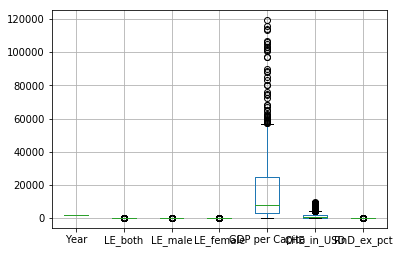

In [3]:
data.boxplot()

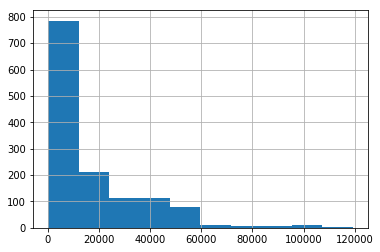

In [9]:
data['GDP per Capita'].hist()


#data['GDP per Capita'] = data['GDP per Capita'].apply(log10)


In [10]:
data['LOG GDP per Capita'] = data['GDP per Capita'].transform(math.log10)
#data['GDP per Capita'].transform(math.log10)
#print(data.groupby(['Country']).mean())
group = data.groupby(['Country']).mean()
#group.boxplot(column=['GDP per Capita'])
#display(group['GDP per Capita'])
#group.hist(column=['GDP per Capita'], bins=15)


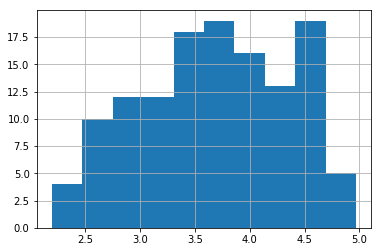

In [12]:
hist = group['LOG GDP per Capita'].hist()



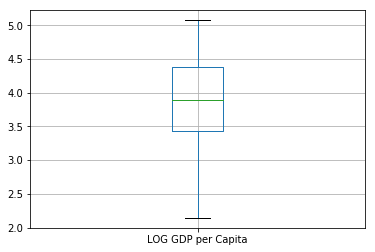

In [13]:
data.boxplot(column=['LOG GDP per Capita'])


In [14]:
group = data.groupby(['Country','Income Level']).mean()
display(group)

Year  \
Country                                            Income Level                
Albania                                            LM            2007.500000   
Algeria                                            LM            2003.000000   
Argentina                                          H             2014.000000   
                                                   UM            2006.500000   
Armenia                                            L             2000.500000   
                                                   LM            2008.500000   
Australia                                          H             2006.750000   
Austria                                            H             2007.500000   
Azerbaijan                                         L             2001.000000   
                                                   LM            2005.500000   
                                                   UM            2012.000000   
Bahrain                                            H             2014.000000   
Belarus                                            LM            2003.000000   
                                                   UM            2011.000000   
Belgium                                            H             2007.500000   
Bolivia (Plurinational State of)                   LM            2003.000000   
Bosnia and Herzegovina                             LM            2005.000000   
                                                   UM            2011.833333   
Botswana                                           UM            2010.000000   
Brazil                                             LM            2003.500000   
                                                   UM            2008.272727   
Brunei Darussalam                                  H             2003.000000   
Bulgaria                                           LM            2002.500000   
                                                   UM            2010.500000   
Burkina Faso                                       L             2004.875000   
Burundi                                            L             2009.000000   
Cabo Verde                                         LM            2011.000000   
Cambodia                                           L             2002.000000   
                                                   LM            2015.000000   
Canada                                             H             2007.000000   
...                                                                      ...   
Sudan                                              L             2002.500000   
Sweden                                             H             2008.428571   
Switzerland                                        H             2006.000000   
Tajikistan                                         L             2007.000000   
                                                   LM            2014.500000   
Thailand                                           LM            2004.500000   
                                                   UM            2013.250000   
The former Yugoslav republic of Macedonia          LM            2003.500000   
                                                   UM            2011.500000   
Togo                                               L             2012.000000   
Trinidad and Tobago                                H             2010.000000   
                                                   UM            2002.500000   
Tunisia                                            LM            2006.555556   
                                                   UM            2012.000000   
Turkey                                             LM            2002.000000   
                                                   UM            2008.250000   
Uganda                                             L             2006.000000   
Ukraine                                            L             2000.50

In [52]:
def truncate_column(c):
    return c.split(' ')[0]


datawb = pd.read_csv('data/raw/worldbank-2.csv')
display(datawb.head())

country_list=datawb['Country Name'].unique().tolist()
#print(country_list)

variable_list=datawb['Series Name'].unique().tolist()
print(variable_list)

datawb = datawb.drop(['Country Code','Series Code'],axis=1)


datawb = datawb.rename(truncate_column,axis=1)
print(datawb.columns)

display(datawb.head())

for series, df_series in datawb.groupby('Series'):
    print(series)
    print(df_series.columns)
    df_series.drop(['Series'], axis=1, inplace=True)
    print(df_series.columns)
    #print(df_series_filtered['Year'])
   
    df_series_filtered = df_series.set_index('Country')   
    df_series_filtered.columns.names= ['Year']
    df_series_filtered = pd.DataFrame(df_series_filtered.stack())
    df_series_filtered = df_series_filtered.reset_index()
    df_series_filtered = df_series_filtered[df_series_filtered['Year'].astype(float) >= 2000]
    df_series_filtered.set_index(['Country','Year'], inplace=True)
    display(df_series_filtered.head)

    

,Series Name,Series Code,Country Name,Country Code,1990 [YR1990],2000 [YR2000],2008 [YR2008],2009 [YR2009],2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017]
0,"Population, total",SP.POP.TOTL,Afghanistan,AFG,12249114.0,20093756.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
1,"Population, total",SP.POP.TOTL,Albania,ALB,3286542.0,3089027.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
2,"Population, total",SP.POP.TOTL,Algeria,DZA,25912367.0,31183660.0,34860715.0,35465760.0,36117637.0,36819558.0,37565847.0,38338562.0,39113313.0,39871528.0,40606052.0,41318142.0
3,"Population, total",SP.POP.TOTL,American Samoa,ASM,47038.0,57521.0,57030.0,56227.0,55637.0,55320.0,55230.0,55307.0,55437.0,55537.0,55599.0,55641.0
4,"Population, total",SP.POP.TOTL,Andorra,AND,54509.0,65390.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


['Population, total', 'Surface area (sq. km)', 'Population density (people per sq. km of land area)', 'GNI, Atlas method (current US$)', 'GNI per capita, Atlas method (current US$)', 'GNI, PPP (current international $)', 'GNI per capita, PPP (current international $)', 'GDP growth (annual %)', 'GDP per capita growth (annual %)', 'Prevalence of HIV, total (% of population ages 15-49)', 'Incidence of tuberculosis (per 100,000 people)', 'Mortality caused by road traffic injury (per 100,000 people)', 'Access to electricity (% of population)', 'Individuals using the Internet (% of population)', 'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)', 'CO2 emissions (metric tons per capita)', 'Intentional homicides (per 100,000 people)', nan, 'Data from database: World Development Indicators', 'Last Updated: 11/14/2018']
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


,Series,Country,1990,2000,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,"Population, total",Afghanistan,12249114.0,20093756.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
1,"Population, total",Albania,3286542.0,3089027.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
2,"Population, total",Algeria,25912367.0,31183660.0,34860715.0,35465760.0,36117637.0,36819558.0,37565847.0,38338562.0,39113313.0,39871528.0,40606052.0,41318142.0
3,"Population, total",American Samoa,47038.0,57521.0,57030.0,56227.0,55637.0,55320.0,55230.0,55307.0,55437.0,55537.0,55599.0,55641.0
4,"Population, total",Andorra,54509.0,65390.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


Access to electricity (% of population)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                          0
Country                                   Year            
Afghanistan                               2000    0.959756
                                          2008   42.400000
                                          2009   44.854885
                                          2010   42.700000
                                          2011   43.222019
                                          2012   69.100000
                                          2013   67.259552
                                          2014   89.500000
                                          2015   71.500000
                                          2016   84.137138
Albania                                   2000  100.000000
                                          2008  100.000000
                                          2009  100.000000
                                          2010  100.000000
                          

CO2 emissions (metric tons per capita)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                         0
Country                                    Year          
Afghanistan                                2000  0.038506
                                           2008  0.154101
                                           2009  0.241723
                                           2010  0.293837
                                           2011  0.412017
                                           2012  0.350371
                                           2013  0.315602
                                           2014  0.299445
Albania                                    2000  0.978175
                                           2008  1.484311
                                           2009  1.495600
                                           2010  1.578574
                                           2011  1.803715
                                           2012  1.692908
                                          

Data from database: World Development Indicators
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of Empty DataFrame
Columns: [0]
Index: []>

GDP growth (annual %)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                         0
Country                                   Year           
Afghanistan                               2008   3.611368
                                          2009  21.020649
                                          2010   8.433290
                                          2011   6.113685
                                          2012  14.434741
                                          2013   3.900575
                                          2014   2.690522
                                          2015   1.310040
                                          2016   2.366712
                                          2017   2.595542
Albania                                   2000   6.666620
                                          2008   3.760854
                                          2009   3.352610
                                          2010   3.710058
                                          

GDP per capita growth (annual %)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                         0
Country                                   Year           
Afghanistan                               2008   1.040489
                                          2009  17.951089
                                          2010   5.425968
                                          2011   2.879648
                                          2012  10.750252
                                          2013   0.512509
                                          2014  -0.526845
                                          2015  -1.628298
                                          2016  -0.349412
                                          2017   0.071666
Albania                                   2000   7.348639
                                          2008   4.560118
                                          2009   4.051449
                                          2010   4.226219
                                          

GNI per capita, Atlas method (current US$)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                            0
Country                                   Year              
Afghanistan                               2008    360.000000
                                          2009    460.000000
                                          2010    500.000000
                                          2011    560.000000
                                          2012    670.000000
                                          2013    680.000000
                                          2014    650.000000
                                          2015    600.000000
                                          2016    580.000000
                                          2017    570.000000
Albania                                   2000   1170.000000
                                          2008   3950.000000
                                          2009   4230.000000
                                          2010   4360.0

GNI per capita, PPP (current international $)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                            0
Country                                   Year              
Afghanistan                               2008   1250.000000
                                          2009   1490.000000
                                          2010   1590.000000
                                          2011   1680.000000
                                          2012   1900.000000
                                          2013   1940.000000
                                          2014   1950.000000
                                          2015   1940.000000
                                          2016   1970.000000
                                          2017   2000.000000
Albania                                   2000   4150.000000
                                          2008   8270.000000
                                          2009   8670.000000
                                          2010   9540.0

GNI, Atlas method (current US$)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                            0
Country                                   Year              
Afghanistan                               2008  9.888574e+09
                                          2009  1.279706e+10
                                          2010  1.442990e+10
                                          2011  1.666673e+10
                                          2012  2.069665e+10
                                          2013  2.148262e+10
                                          2014  2.133585e+10
                                          2015  2.025955e+10
                                          2016  1.997900e+10
                                          2017  2.018235e+10
Albania                                   2000  3.599111e+09
                                          2008  1.165414e+10
                                          2009  1.238874e+10
                                          2010  1.27095

GNI, PPP (current international $)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                            0
Country                                   Year              
Afghanistan                               2008  3.418109e+10
                                          2009  4.168437e+10
                                          2010  4.573234e+10
                                          2011  4.988882e+10
                                          2012  5.837406e+10
                                          2013  6.157930e+10
                                          2014  6.401440e+10
                                          2015  6.557368e+10
                                          2016  6.814018e+10
                                          2017  7.105027e+10
Albania                                   2000  1.281163e+10
                                          2008  2.437391e+10
                                          2009  2.539080e+10
                                          2010  2.77933

Incidence of tuberculosis (per 100,000 people)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                      0
Country                                    Year       
Afghanistan                                2000  190.0
                                           2008  189.0
                                           2009  189.0
                                           2010  189.0
                                           2011  189.0
                                           2012  189.0
                                           2013  189.0
                                           2014  189.0
                                           2015  189.0
                                           2016  189.0
Albania                                    2000   22.0
                                           2008   16.0
                                           2009   17.0
                                           2010   17.0
                                           2011   17.0
                                   

Individuals using the Internet (% of population)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                         0
Country                                   Year           
Afghanistan                               2008   1.840000
                                          2009   3.550000
                                          2010   4.000000
                                          2011   5.000000
                                          2012   5.454545
                                          2013   5.900000
                                          2014   7.000000
                                          2015   8.260000
                                          2016  10.595726
Albania                                   2000   0.114097
                                          2008  23.860000
                                          2009  41.200000
                                          2010  45.000000
                                          2011  49.000000
                                          

Intentional homicides (per 100,000 people)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                          0
Country                                    Year           
Afghanistan                                2009   3.981527
                                           2010   3.412819
                                           2011   4.143581
                                           2012   6.345906
Albania                                    2000   4.196069
                                           2008   3.108651
                                           2009   2.869068
                                           2010   4.318957
                                           2011   4.851949
                                           2012   5.376641
                                           2013   4.248062
                                           2014   4.005786
                                           2015   2.257682
                                           2016   2.698926
Algeria                   

Last Updated: 11/14/2018
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of Empty DataFrame
Columns: [0]
Index: []>

Mortality caused by road traffic injury (per 100,000 people)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                          0
Country                                    Year           
Afghanistan                                2000  15.500000
                                           2010  15.300000
                                           2015  15.200000
Albania                                    2000  15.400000
                                           2010  15.400000
                                           2015  13.600000
Algeria                                    2000  23.500000
                                           2010  24.700000
                                           2015  23.700000
Angola                                     2000  20.000000
                                           2010  20.800000
                                           2015  24.400000
Antigua and Barbuda                        2000   8.900000
                                           2010   5.700000
                          

PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                          0
Country                                    Year           
Afghanistan                                2000  56.092028
                                           2010  46.536809
                                           2011  50.483960
                                           2012  50.653945
                                           2013  50.968831
                                           2014  49.036091
                                           2015  62.080234
                                           2016  62.854857
Albania                                    2000  14.320845
                                           2010  15.335690
                                           2011  14.646135
                                           2012  14.562992
                                           2013  15.635917
                                           2014  16.748862
                          

Population density (people per sq. km of land area)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                          0
Country                                   Year            
Afghanistan                               2000   30.778047
                                          2008   41.806867
                                          2009   42.894849
                                          2010   44.118443
                                          2011   45.505314
                                          2012   47.019205
                                          2013   48.604123
                                          2014   50.176179
                                          2015   51.674929
                                          2016   53.083405
                                          2017   54.422205
Albania                                   2000  112.738212
                                          2008  107.566204
                                          2009  106.843759
                          

Population, total
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                            0
Country                                   Year              
Afghanistan                               2000  2.009376e+07
                                          2008  2.729403e+07
                                          2009  2.800433e+07
                                          2010  2.880317e+07
                                          2011  2.970860e+07
                                          2012  3.069696e+07
                                          2013  3.173169e+07
                                          2014  3.275802e+07
                                          2015  3.373649e+07
                                          2016  3.465603e+07
                                          2017  3.553008e+07
Albania                                   2000  3.089027e+06
                                          2008  2.947314e+06
                                          2009  2.92751

Prevalence of HIV, total (% of population ages 15-49)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                         0
Country                                    Year          
Albania                                    2000  0.100000
                                           2008  0.100000
                                           2009  0.100000
                                           2010  0.100000
                                           2011  0.100000
                                           2012  0.100000
                                           2013  0.100000
                                           2014  0.100000
                                           2015  0.100000
                                           2016  0.100000
                                           2017  0.100000
Algeria                                    2000  0.100000
                                           2008  0.100000
                                           2009  0.100000
                                          

Surface area (sq. km)
Index(['Series', 'Country', '1990', '2000', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')
Index(['Country', '1990', '2000', '2008', '2009', '2010', '2011', '2012',
       '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


<bound method NDFrame.head of                                                           0
Country                                   Year             
Afghanistan                               2000     652860.0
                                          2008     652860.0
                                          2009     652860.0
                                          2010     652860.0
                                          2011     652860.0
                                          2012     652860.0
                                          2013     652860.0
                                          2014     652860.0
                                          2015     652860.0
                                          2016     652860.0
                                          2017     652860.0
Albania                                   2000      28750.0
                                          2008      28750.0
                                          2009      28750.0
          